In [1]:
import numpy as np
from scipy.misc import toimage
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import io
import tensorflow as tf

%matplotlib inline

# Federated Learning : Improving comms notes

These notes are used to track the methods that are used within the paper : 


[FEDERATED LEARNING: STRATEGIES FOR IMPROVING COMMUNICATION EFFICIENCY](http://arxiv.org/abs/1610.05492)

This paper outlines how to improve network communications in a federated learnig environment. The parameter updates that are transimitted, per device, back to a centralized parameter server can decrease overall system throughput substantially. We will use this notebook as a way to explore some of the transformation methodologies used.

## Notation

$W$ - initial model parameters that will be transmitted to the hosts

$\mathbb{R}^{d_{1} x d_{2}}$ - matrix of real numbers where $d_{1}$ and $d_{2}$ represent the model input dimensions and output dimensions, respectively.

$t$ - integer tracking the round, or number of iterations, this process has been performed

$W_{t}$ - initial (or current) model 

$S_{t}$ - set of clients available where we can distribute the model to

$n_{t}$ - integer tracking the number of nodes participating in this process

$W_{t}^{1}, W_{t}^{2}, \ldots , W_{t}^{n_{t}}$ - set of updates local models at each time step over each set of nodes

$H_{t}^{i} := W{t}^{i} - W_{t}, \text{for} \ i \in S_{t}$ - the update of a client at a given time step. The difference between parameters at $(t+1) - t$

$\eta$ - centralized learning rates

## Overview

The parameters that are assumed within this model are defined as

$W \in \mathbb{R}^{d_1 x d_2}$

This parameter distribution, training, and update process is iterative. We will assume that $t = 0$ is the first round of this process.

At time $t \ge 0$ the server will distribute the current model parameters $W_{t}$ to a subset $S_{t}$ of $n_{t}$ clients.

The update cycles can be single steps of multiple steps of SGD taken over a client's local datasets. These updates are sent back to the server and a global update ic computed as :

$$ W_{t+1} = W_{t} + \eta_{t}H_{t}, \ \ \ H_{t} := \frac{1}{n_{t}} \sum_{i \in S_{t}} H_{t}^{i} $$

In words, we can see that the updated parameter matrix is a sum of the original parameter space plus the summed updates of the clients that consists of the difference of the previous parameter matrix and the new, updated, parameter matrix.

The idea is the minimize the amount of communcation overhead by representing $H_{t}^{i}$. 

We will now review the two approaches outline within the paper.

## Structured Update

In this case we're going to pre-specify the structure of $H_{t}^{i}$.

### Low Rank 

Here we enforce a bounding on $H_{t}^{i} \in \mathbb{R}^{d_{1} x d_{2}}$ to be of low rank $k$, where $k$ is a fixed number.

This requires that we express $H_{t}^{i}$ as a product of two matrices.

$$ H_{t}^{i} = A_{t}^{i}B_{t}^{i} $$

where

$$ A_{t}^{i} \in \mathbb{R}^{d_{1} x k}, B_{t}^{i} \in \mathbb{R}^{k x d_{2}} $$

Here we can see the bounding of the rank K over the column space and row space of the respective matrices defined above.

### Random Mask

Random masking is a bit different in that the authors are trying to restrict $H_{t}^{i}$ to be sparse. They take the approach of generating the sparse "mask" every each round of training for each client, independently.

Once they've generated and applied this mask to $H_{t}^{i}$ we can then only transmit the non-zero entries of the matrix back to the centralized parameter server.

In [2]:
# random mask example

for i in range(10):
    rand_mat = np.random.rand(5,5)
    print(rand_mat)

    mask = np.random.choice([True, False], size=(5,5))

    print(rand_mat * mask)

[[0.37273288 0.37044459 0.65182003 0.10166379 0.06097416]
 [0.14750606 0.88525255 0.47471904 0.90438684 0.85763023]
 [0.28702413 0.53754398 0.17847662 0.80663598 0.97645826]
 [0.54271045 0.10274996 0.47252215 0.47035657 0.98372558]
 [0.31032767 0.59428442 0.94144556 0.41962019 0.8778428 ]]
[[0.37273288 0.37044459 0.65182003 0.10166379 0.06097416]
 [0.14750606 0.         0.47471904 0.90438684 0.        ]
 [0.         0.         0.17847662 0.80663598 0.97645826]
 [0.54271045 0.         0.47252215 0.47035657 0.98372558]
 [0.         0.         0.94144556 0.41962019 0.        ]]
[[0.8216995  0.64327215 0.2636716  0.91463054 0.39264698]
 [0.43795556 0.08148498 0.01706277 0.20059502 0.1302347 ]
 [0.76815752 0.94630677 0.92258022 0.31050166 0.50240623]
 [0.76124367 0.68396606 0.10369729 0.72925216 0.19375556]
 [0.02756239 0.61009921 0.11715617 0.95808076 0.58471186]]
[[0.         0.64327215 0.         0.         0.39264698]
 [0.43795556 0.         0.         0.20059502 0.        ]
 [0.       

In [3]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)

In [4]:
features, labels = load_cfar10_batch('/home/ed/Documents/code/fed_lrn/cifar-10-batches-py', 1)
label_names = load_label_names()

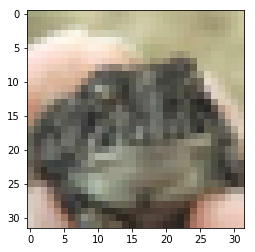

In [5]:
imshow(features[25])

In [11]:
# Reset the graph - removing all existing variables, graph defns, etc.
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')

# Labels
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')

# Probability that will be used for tf.nn.dropout()
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# sample conv net that we can use to model the matrix manipulations outlined above.
def simple_conv(input_data, keep_prob):
    """
    Simple convolutional network
    """
    
    # conv filters
    conv_filter_1 = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv_filter_2 = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv_filter_3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 256], mean=0, stddev=0.08))
    conv_filter_4 = tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 512], mean=0, stddev=0.08))

    # layer 1 -> 2
    conv1 = tf.nn.conv2d(input_data, conv_filter_1, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)
    
    # layer 2 -> 3
    conv2 = tf.nn.conv2d(conv1_bn, conv_filter_2, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
    
    # layer 3 -> 4
    conv3 = tf.nn.conv2d(conv2_bn, conv_filter_3, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # flatten output
    flatten = tf.contrib.layers.flatten(conv3_bn)
    
    # layer 4 -> layer 5 (fully connected)
    fc1 = tf.contrib.layers.fully_connected(inputs=flatten, num_outputs=128, activation_fn=tf.nn.relu)  
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc1 = tf.layers.batch_normalization(fc1)
    
    # layer 5 -> 6
    fc2 = tf.contrib.layers.fully_connected(inputs=fc1, num_outputs=256, activation_fn=tf.nn.relu)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    fc2 = tf.layers.batch_normalization(fc2)
    
    # layer 6 -> 7 
    fc3 = tf.contrib.layers.fully_connected(inputs=fc2, num_outputs=512, activation_fn=tf.nn.relu)
    fc3 = tf.nn.dropout(fc3, keep_prob)
    fc3 = tf.layers.batch_normalization(fc3)
    
    # layer 7 -> 8 
    fc4 = tf.contrib.layers.fully_connected(inputs=fc3, num_outputs=1024, activation_fn=tf.nn.relu)
    fc4 = tf.nn.dropout(fc4, keep_prob)
    fc4 = tf.layers.batch_normalization(fc4)
    
    # layer 8 -> 9
    out = tf.contrib.layers.fully_connected(fc4, num_outputs=10, activation_fn=None)
    
    return out

# hyper params
batch_size = 128
learning_rate = 0.001
epochs = 10
keep_probability = 0.7

cifar10_dataset_folder_path = '/home/ed/Documents/code/fed_lrn/cifar-10-batches-py'

logits = simple_conv(x, keep_prob)
model = tf.identity(logits, name='logits')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32), name='accuracy')

In [12]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x - min_val) / (max_val - min_val)
    return x
    
def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    return encoded

def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)
    
    pickle.dump((features, labels), open(filename, 'wb'))
    
def preprocess_and_save_data(cifar10_fs_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []
    
    for batch_i in range(1, (n_batches + 1)):
        features, labels = load_cfar10_batch('/home/ed/Documents/code/fed_lrn/cifar-10-batches-py', batch_i)
    
        index_of_validation = int(len(features) * 0.1)

        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation],
                             'preprocess_batch_' + str(batch_i) + '.p')

        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])
    
    _preprocess_and_save(normalize, one_hot_encode,
                        np.array(valid_features), np.array(valid_labels),
                        'preprocess_validation.p')
    
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']
    
    _preprocess_and_save(normalize, one_hot_encode,
                        np.array(test_features), np.array(test_labels),
                        'preprocess_training.p')
    
    
    
def train_model(session, optimizer, keep_probability, feature_batch, label_batch):
    """ 
    Method to train model outlined above
    """
    session.run(optimizer,
               feed_dict={
                   x: feature_batch,
                   y: label_batch,
                   keep_prob: keep_probability,
               })

    
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))
    
def batch_data(features, labels, batch_size):
    """
    Batch the data using a generator approach
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start: end]

def load_preprocess_batch(batch_id, batch_size):
    """
    Load the preprocessed data from disc -- CIFAR10/100 can be found at the URL below :
    
    https://www.cs.toronto.edu/~kriz/cifar.html
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, 'rb'))
    
    return batch_data(features, labels, batch_size)

In [13]:
preprocess_and_save_data('/home/ed/Documents/code/fed_lrn/cifar-10-batches-py', normalize, one_hot_encode)

In [14]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [15]:
# training loop

save_model_path = './saved_model'
print("Training...")

with tf.Session() as sess:
    # intialize all variables
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        n_batches = 5
        
        for batch_i in range(1, n_batches+1):
            for batch_features, batch_labels in load_preprocess_batch(batch_i, batch_size):
                train_model(sess, optimizer, keep_probability, batch_features, batch_labels)
            
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
        
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0996 Validation Accuracy: 0.277000
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.7659 Validation Accuracy: 0.340400
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.1903 Validation Accuracy: 0.458800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.2540 Validation Accuracy: 0.512800
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.1441 Validation Accuracy: 0.558200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.0820 Validation Accuracy: 0.595000
Epoch  2, CIFAR-10 Batch 2:  Loss:     0.8814 Validation Accuracy: 0.594200
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.7792 Validation Accuracy: 0.629600
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.8596 Validation Accuracy: 0.632800
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.6251 Validation Accuracy: 0.661800
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.7826 Validation Accuracy: 0.671400
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.6416 Validation Accuracy: 0.690800
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.5097 Validation Accuracy: 0.681400
